<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Transfer%20Learning/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Pytorch Transfer Learning
Transfer learning involves taking the parameters of what one model has learned on another dataset and aplying to other


In [47]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

2.5.1+cu121
0.20.1+cu121


Let's import the code from the going modular section

In [48]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


In [49]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
!nvidia-smi

Tue Nov 19 20:25:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              30W /  70W |    791MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

In [51]:
import os
import zipfile

from pathlib import Path
import requests
# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the images folder doesn't exist, download it an prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping download")
else:
  print(f"did not find {image_path}, downloading it")
  image_path.mkdir(parents=True, exist_ok=True)

   # Download dataset
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print(" Downloading it")
      f.write(request.content)
  # Unzip dataa
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data")
    zip_ref.extractall(image_path)

    # remove zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

did not find data/pizza_steak_sushi, downloading it
Unzipping data


In [52]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders
Now we have got some data and will turn into Pytorch DataLoaders.

* Important Point: When using a pretrained model, it is important that the data that you pass through it is transformed in the same way the data the model was trained on

In [53]:
from going_modular.going_modular import data_setup

### 2.1 Creating transforms (manual creation)

Using the same setup of ImageNet

In [54]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), # Resize for height and width = 224
                                        transforms.ToTensor(),  # Get images into range [0, 1]
                                        normalize]) # Equal to ImageNet

In [55]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792d1a1a5b40>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)


In [56]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = best available
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [57]:
# Get the transformeds used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [58]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792d1a1a7700>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. Pytorch domain libraries
2. Libraries like timm (torch image models)
3. Hugging face
4. Papers with code

### 3.1 Wich pretrained model should  i use?
*Experimenting is the best*

Three things to consider?
1. Speed - how fast does it run?
2. Size - how big it is?
3. Performance - how well it works?

For my case(deploying Food Vision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of the Bitter Lesson, if we had infinite compute we'd likely pick the biggest model + most parameters + most general we could

### 3.2 Setting up a pretrained model
Want to create an instance of a pretrained EffNetB0

In [59]:
# Creating a pretrained moel
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [60]:
# Print with torchinfo

from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable" ],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output later to suit my needs

With a feature extractor model, typically i will freeze the base layers of pretrained/foundation model and update the output layers
to suit my own problem

In [61]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [62]:
# Updata the classifier head of my model to suit my problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(in_features=1280, # Feature vector coming ing
                                            out_features=(len(class_names))).to(device) # How many classes
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [63]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable" ],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [64]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
# Import train function
from going_modular.going_modular import engine

# Set the seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 12.404 seconds


## 5. Evaluate model by plotting loss functions

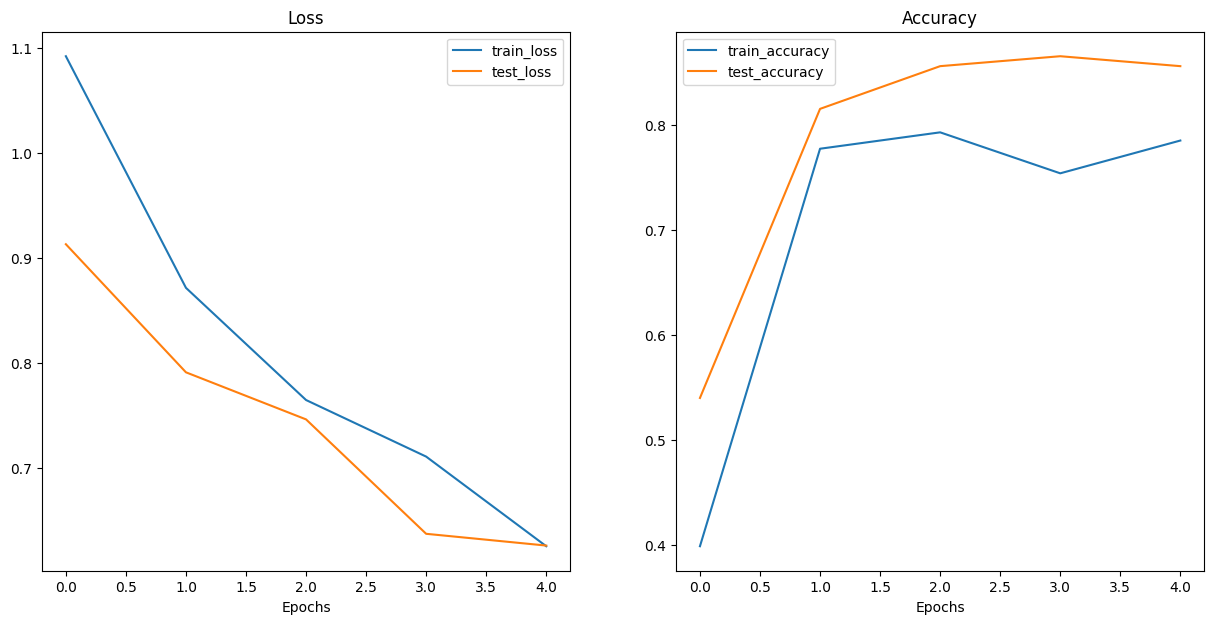

In [66]:
import requests

try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper functions, downloading it...")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plotting
plot_loss_curves(results)

## 6. Make predictions on images from test set
Some thing to keep in mind when making predictions/inference on test data

We have to make sure that our data is:
* Same shape - images need to be same shape as model was trained on
* same datatype - custom data should be in the same data type
* same device - data should be on the same device
* same transform - if you've transformed your data, you should do transform this data too

Let's create a function called pred_and_plot_image():
1. Take in a pretrained model, a list of class names, a filpath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `MODEL.EVAL()`mode to make sure it's ready for infrence
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities labels using `torch.argmax()`
10 .Plot the image with `matplotlib`and set the title to prediction label from step 9 and prediction probability from step 8

In [67]:
from PIL import Image
from matplotlib import pyplot as plt
from typing import List, Tuple # Import List from typing module
# Creating the function
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int] = (224, 224),
                        device: torch.device=device,
                        transform: torchvision.transforms = None):
  """ This function will take in a image and model and will predict it"""
  # 1. Open the image with PIL
  img = Image.open(image_path)

  # 2. Transform if necessary
  if transform is not None:
    image_transform = transform(img)
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])

    ### Predict on image ###

  # 3. Make sure model is on the device
  model.to(device)

  # 4 Turn on eval mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (batch size)
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # Make a prediction on image by passing it to the model, also ensure its on the device
    target_image_pred = model(transformed_image.to(device))

  # Convert logits into probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # COnvert probabilities into predictions
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

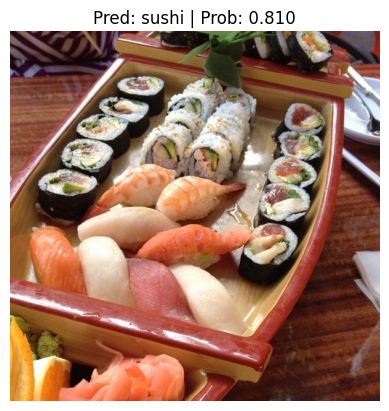

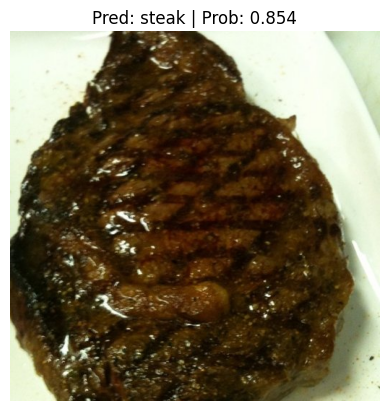

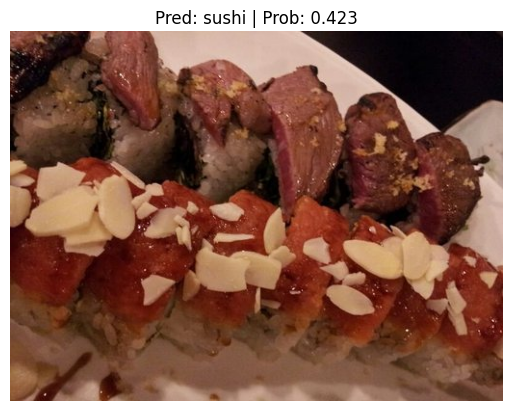

In [68]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                            k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 6.1 Getting image to predict on

In [82]:
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

data/04-pizza-dad.jpeg already exists, skipping download.


UnidentifiedImageError: cannot identify image file '/content/data/04-pizza-dad.jpeg'